<a href="https://colab.research.google.com/github/Fuiakoi/heart_disease/blob/main/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installer YDF biblioteket

In [1]:
# !pip install ydf==0.4.0 -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 29.3 MB/s eta 0:00:00


# Importer de nødvendige biblioteker:

In [1]:
import ydf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Load datasættet ind i Colabs hukommelse

In [2]:
# Link til datasæt
path = "https://raw.githubusercontent.com/Fuiakoi/heart_disease/main/heart_disease.csv"
dataset = pd.read_csv(path)
label = "target"

# dataset.drop(columns = ['max heart rate'], inplace = True)

# Vis de første fem eksempler
dataset.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


# Impute datasættet, så der ingen missing values er

In [5]:
# Erstat 0 værdierne med NaN i 'chest pain type', 'resting bp s', 'cholesterol' og 'max heart rate' kolonnerne
#features = ['chest pain type', 'resting bp s', 'cholesterol', 'max heart rate']
#dataset[features] = dataset[features].replace(0)

# Udfyld de manglende værdier med gennemsnittet af hver kolonne
#dataset.fillna(dataset.mean(), inplace = True)

# Vis de første fem eksempler
#dataset.head(5)

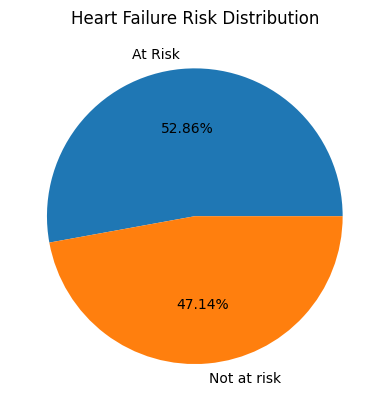

In [3]:
# Count the number of individuals at risk and not at risk of heart failure
at_risk_count = dataset[dataset[label] == 1].shape[0]
not_at_risk_count = dataset[dataset[label] == 0].shape[0]

# Create labels and counts for the pie chart
labels = ['At Risk', 'Not at risk']
counts = [at_risk_count, not_at_risk_count]

# Plot the pie chart
plt.pie(x=counts, labels=labels, autopct='%.2f%%')
plt.title('Heart Failure Risk Distribution')
plt.show()

# Stratify og split datasættet op i træningsæt og testingsæt

In [4]:
# Use the ~20% of the examples as the testing set
# and the remaining ~80% of the examples as the training set

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1)

for train_index, test_index in splitter.split(dataset, dataset[label]):
    train_dataset = dataset.iloc[train_index]
    test_dataset = dataset.iloc[test_index]

print("Training examples: ", len(train_dataset))
print("Testing examples: ", len(test_dataset))

Training examples:  952
Testing examples:  238


# Træn datasættet

In [5]:
# Assuming you have already trained your model and have access to the trained model object
model = ydf.CartLearner(label = label).train(train_dataset)
# model = ydf.CartLearner(label = label, growing_strategy="BEST_FIRST_GLOBAL").train(train_dataset)

model.plot_tree()
# Selvom der er 952 mennesker i træningssættet, bliver kun 876 af dem brugt
# Dette skyldes at nogle mennesker automatisk bliver reserveret til validering
# og tree pruning
# Omkring 10% ud til validering

Train model on 952 examples
Model trained in 0:00:00.029266


# Se hvor akkurat det første decision tree er

In [20]:
train_evaluation = model.evaluate(train_dataset)
print("train accuracy: {:.2f}%".format(train_evaluation.accuracy * 100))
# 86.24%

test_evaluation = model.evaluate(test_dataset)
print("test accuracy: {:.2f}%".format(test_evaluation.accuracy * 100))
# 86.97%

model.evaluate(test_dataset)

train accuracy: 99.26%
test accuracy: 94.12%


Label \ Pred,1,0
1,123,11
0,3,101


# Find en god threshold

Accuracy: 84.87%
Precision: 95.92%
Recall: 74.60%


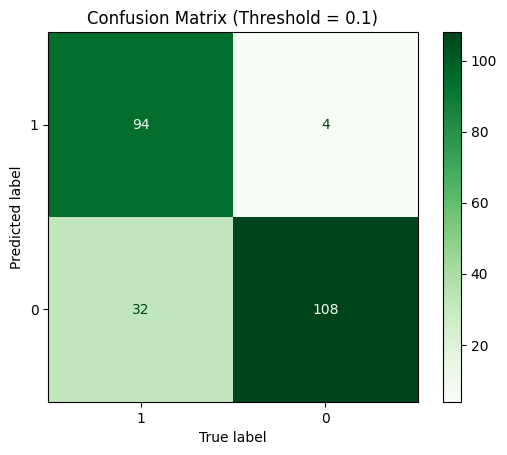


Accuracy: 91.60%
Precision: 95.69%
Recall: 88.10%


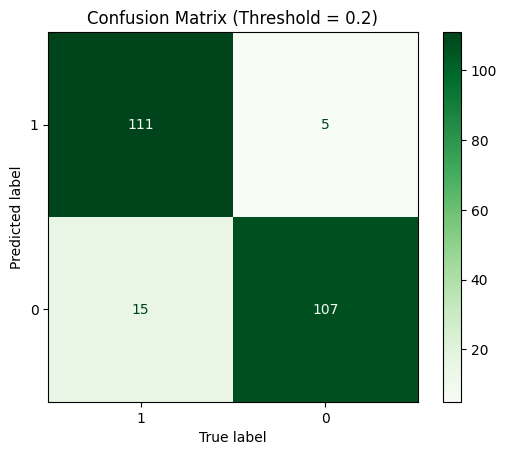


Accuracy: 90.76%
Precision: 92.62%
Recall: 89.68%


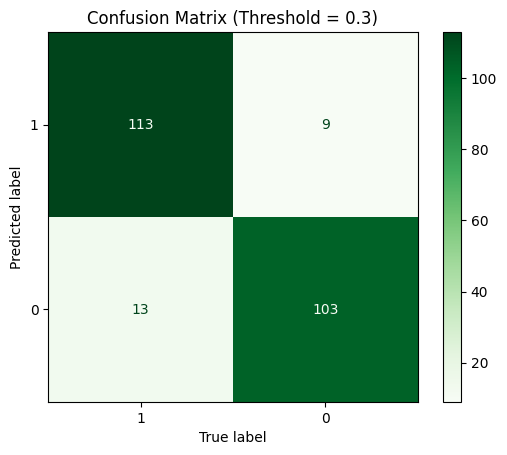


Accuracy: 93.70%
Precision: 92.37%
Recall: 96.03%


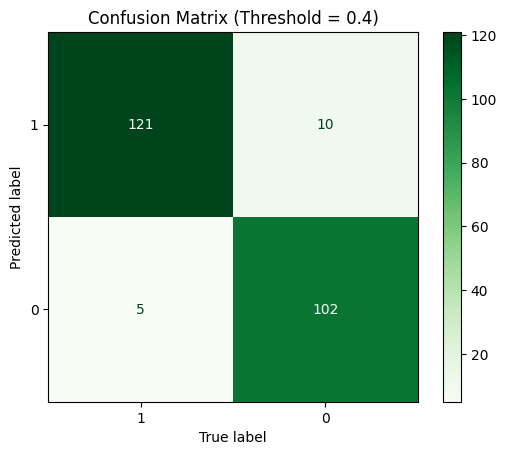


Accuracy: 94.12%
Precision: 91.79%
Recall: 97.62%


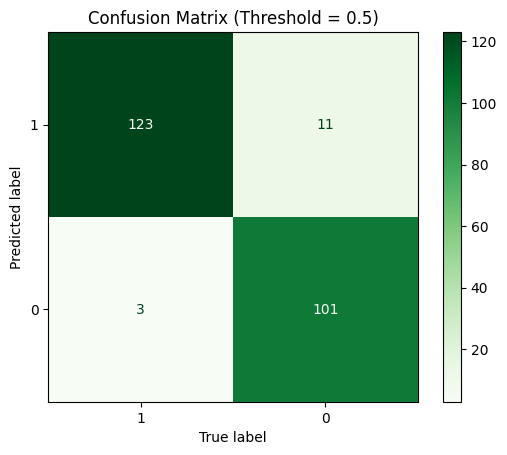


Accuracy: 93.70%
Precision: 91.11%
Recall: 97.62%


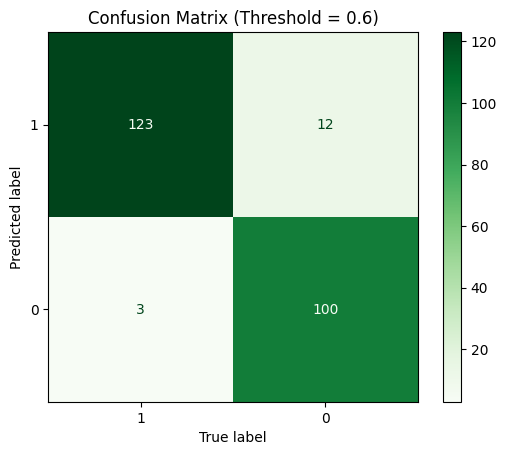


Accuracy: 92.86%
Precision: 89.78%
Recall: 97.62%


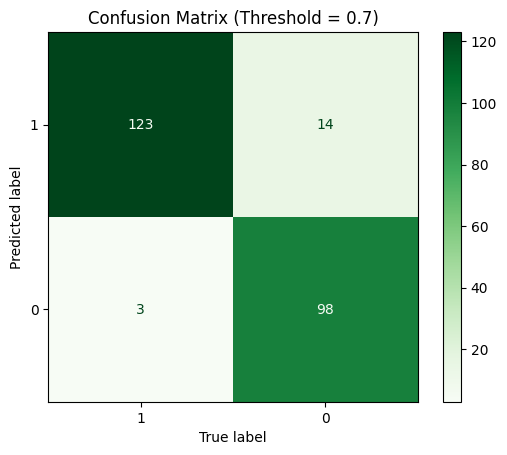


Accuracy: 93.28%
Precision: 89.86%
Recall: 98.41%


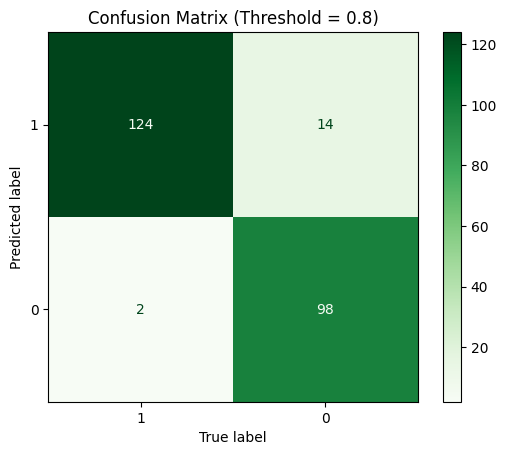


Accuracy: 90.34%
Precision: 85.03%
Recall: 99.21%


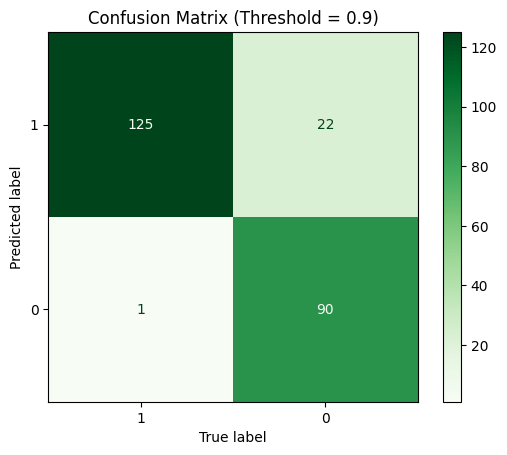


Accuracy: 52.94%
Precision: 52.94%
Recall: 100.00%


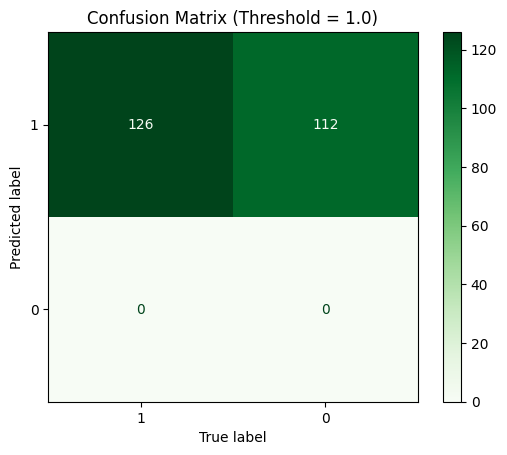

In [19]:
# Get predictions on the test dataset (probabilities)
predictions = model.predict(test_dataset)

# Define a range of threshold values to test
thresholds = np.arange(0.1, 1.1, 0.1)

# Loop through each threshold value
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    binary_predictions = (predictions <= threshold).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset[label], binary_predictions)

    # Calculate precision and recall
    precision = precision_score(test_dataset[label], binary_predictions, zero_division=0)
    recall = recall_score(test_dataset[label], binary_predictions)

    # Print accuracy, precision, and recall
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}%".format(precision * 100))
    print("Recall: {:.2f}%".format(recall * 100))

    # Compute confusion matrix
    cm = confusion_matrix(test_dataset[label], binary_predictions)

    # Rearrange the confusion matrix
    cm_custom = np.array([[cm[1, 1], cm[0, 1]],
                          [cm[1, 0], cm[0, 0]]])

    # Plot the custom confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=[1, 0])
    disp.plot(cmap='Greens')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title(f'Confusion Matrix (Threshold = {round(threshold, 2)})')
    plt.show()
    print()

# Ændre på dine hyperparametre, så modellen bliver mere akkurat

In [11]:
# tuner = ydf.RandomSearchTuner(num_trials = 50, automatic_search_space=True)

tuner = ydf.RandomSearchTuner(num_trials = 50)
tuner.choice("shrinkage", [0.2, 0.1, 0.05])
tuner.choice("subsample", [1.0, 0.9, 0.8])
tuner.choice("max_depth", [3, 4, 5, 6])

learner = ydf.GradientBoostedTreesLearner(
    label = label,
    num_trees = 100,
    tuner = tuner,
)
model = learner.train(train_dataset)
model.evaluate(test_dataset)
# 93.28%

Train model on 952 examples
Model trained in 0:00:09.457774


Label \ Pred,1,0
1,120,10
0,6,102


# Lav en Random Forest

In [12]:
model = ydf.RandomForestLearner(label = label).train(train_dataset)

model.evaluate(test_dataset)
# 89.5%

Train model on 952 examples
Model trained in 0:00:00.366690


Label \ Pred,1,0
1,117,16
0,9,96


# Lav en Gradient Boosted Tree

In [13]:
model = ydf.GradientBoostedTreesLearner(label = label).train(train_dataset)

model.evaluate(test_dataset)

# model.analyze_prediction(test_dataset.iloc[:1])
# model.predict(test_dataset)

# 94.12%

Train model on 952 examples
Model trained in 0:00:00.553813


Label \ Pred,1,0
1,123,11
0,3,101


# Træn datasættet på cross-validation

In [14]:
learner = ydf.RandomForestLearner(label = label)
evaluation = learner.cross_validation(dataset, folds=10)

evaluation
# 90.34%

Label \ Pred,1,0
1,582,68
0,47,493
